# Machine Learning for Explanation of Sub-grid Convective Precipitation: A Case Study over CONUS using a Convection-allowing Model:

## Technical demonstration document with examples

**Hyoungseok Kang and Ardeshir Ebtehaj**


Github repository for CPF demonstration: https://github.com/hs-safl/CPF_demo

---

## Table of Contents
1. [Introduction](#1)
2. [Methodology](#2)
3. [Data](#3)
4. [Skill evaluation](#4)
    - [4.1 Data preparation](#41)
    - [4.2 Training models](#42)
    - [4.3 Detection of CPFs](#43)
    - [4.4 Estimation of CPFs](#44)
5. [Storm event examples](#5)

---

<a name="1"></a> <br>
## 1. Introduction

A predictive understanding of key dynamic, thermodynamic, and cloud microphysical predictors controlling the sub-grid scale occurrence of convective precipitation is important to shrink the uncertainties in climate projects of changes in extreme precipitation given simulations of the general circulation models. This paper studies the performance of the eXtreme gradient boosting decision trees for the detection of convective precipitation features (CPF) and the estimation of their sub-grid extent through learning from observationally contained hourly simulations at 3-km grids by the convection-allowing High-Resolution Rapid Refresh (HRRR) weather forecasting model over the conterminous United States. Accounting for the imbalanced nature of detecting CPFs through a classification problem, the annual results demonstrate that 85\% of CPFs can be detected with a conditional mean absolute error of 8 sub-grid events, given key CPFs predictors at 100 km grids. Seasonal variability of the detection and estimation quality metrics show strong connections with unknown distinct seasonal large-scale environments controlling the space-time dynamics of mesoscale convective systems in summer and winter. Explaining the decision tree through Shapley analyses uncovers that cloud liquid and ice water content are the most important predictors in the detection step; however, the sub-grid extent of CPFs is largely controlled by the mid-level vorticity produced by the heating profiles of the convective systems.

This technical demonstration document show how XGBoost learns subgrid area fractions of convective precipitation over the CONUS, given dynamic and thermodynamic predictors of precipitation at coarse grid resolutions using multi-layer analysis states by HRRR weather model and labels of CPF by the ground-based radar observations.

<center><img src=https://raw.githubusercontent.com/hs-safl/CPF_demo/main/Figures/Figure_01_a.png width=650></center>

Composite reflectivity (a), precipitation rate (b), and convective labels with $>$40 dBZ (c) for a squall line system with a band of convective supercells and stratiform precipitation trailing on May 04, 2021, at 21:00 UTC.

<a name="2"></a> <br>
## 2. Methodology
We use the XGBoost (XGB) decision tree to detect the occurrence and to estimate the number of 3-km convective sub-pixels $n_c$ within 100 km coarse-grained grids. The data points sampled from 2019 to 2021 are used for training and validation , and those sampled in 2022 for testing. For the detection (estimation) step, the weighted cross entropy (mean squared error) loss function is used. 

The weighted cross entropy loss accounts for the effects of imbalanced labels as the CPFs are rare, and their labels are significantly less than the non-convective ones. In fact, after coarse-graining of the simulations, only 6.1\% of data contains at least one sub-grid CPF. The weighted log-loss or cross-entropy loss for a binary classification is expressed as 
\begin{equation}
    \mathcal{L}_\alpha(\mathbf{x},\boldsymbol{\theta}) = -\sum_{i=1}^N \left[\alpha y_i\log \hat{y}_i+(1-y_i)\log(1-\hat{y}_i)\right],\label{eq:01}
\end{equation}
where $\alpha$ is the imbalance parameter, $y_i=1 (0)$ is the label for CPFs (non-CPFs), and $\hat{y}_i$ is the probability of $y_i=1$ obtained as function of the input features $\mathbf{x}$ passed through the decision tree with trainable parameters $\boldsymbol{\theta}$. This probability is obtained through the logistic function. Improved detection of convective precipitation is expected for $\alpha>1$ when the training set is imbalanced towards non-CPF events. For the hyperparameter tuning of the tree, we use grid search to find optimal values of the maximum tree depth, learning rate, as well as $\ell_1$-, and $\ell_2$-norm regularization parameters.

When sub-grid convective activities are detected, the XGB decision tree is trained based on a regression loss as follows:
$\mathcal{L}(\mathbf{x},\boldsymbol{\theta}) = \sum_{i=1}^N \left(n_c^i - \hat{n}_c^i \right)^2$
where $n_c$ and $\hat{n}_c$ are the actual and estimated number of sub-grid CPFs. 

<a name="3"></a> <br>
## 3. Data

The input data are observational constrained coarse-grained hourly HRRR simulations of 74 analysis state variables at 3 km resolution throughout the depth of the atmosphere from 2019 to 2022 at 100 km to resemble the spatial scale of GCM simulations. The HRRR simulations are concatenated by data assimilation of a suite of conventional observations (e.g., aircraft, radiosonde, buoy/ship, and satellites) used for the Rapid Refresh (RAP) as well as three-dimensional radar-reflectivity observations provided through the NOAA's Multi-Radar Multi-Sensor project (MRMS). The surface and integrated predictors are the 2-m air temperature ($T_{2m}$, $\mathrm{K}$), specific humidity ($q_{2m}$, $\mathrm{kg/kg}$), surface pressure ($P_{s}$, $\mathrm{Pa}$), and total precipitable water ($\mathrm{TPW}$, $\mathrm{kg/m^2}$). Atmospheric variables are temperature ($T$), specific humidity ($q$, $\mathrm{kg/kg}$), geopotential height, ($z$, gpm), mixing ratio of liquid water ($q_{l}$, $\mathrm{kg/kg}$) and ice ($q_{i}$, $\mathrm{kg/kg}$), vertical velocity ($v$, $\mathrm{Pa/s}$), and absolute vorticity ($\omega$, $\mathrm{1/s}$) at pressure levels extending from 1000 to 100 hPa with 100 hPa intervals.

Here, for quick emplementation, the downsmapled train and test dataset is provided. For someone who is interested in the complete dataset used in the research paper, those datasets can be downloaded from [https://github.com/hs-safl/CPF_demo](https://github.com/hs-safl/CPF_demo). One can compare the performance presented in the paper with the skill performances evaluated with subsampled test dataset.

<a name="4"></a> <br>
## 4. Skill evaluation

For better readability, most of lines occupying space are placed in "utils.py". One can find and make change of the parameters used in this document.

In [1]:
# Import necessary packages

import os
import numpy as np
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from utils import *
import warnings
from sklearn.model_selection import train_test_split

<a name="41"></a> <br>
### 4.1 Data preparation
Subsampled train dataset is loaded by class "CPF_train_dataset". set *arg_regression=0* when it is for detection and set *arg_regression=1* for estimation. The size of validation set is 1000 and random seed is given for the consistent result. One might try different validation dataset size and random seeed.

In [2]:
# Load training dataset for detection and estimation of CPFs
# df_det_train, df_det_test = train_test_split(CPF_train_dataset(arg_regression=0), test_size=1000, random_state=42)
# df_reg_train, df_reg_test = train_test_split(CPF_train_dataset(arg_regression=1), test_size=1000, random_state=42)

<a name="42"></a> <br>
### 4.2 Training models

In [3]:
# Train XGBs for detection and estimation of CPF
model_train = 0
if model_train == 1:
    num_boost_round = 100
    col_name, df_col_name = column_names()
    target = 'label'
    para_set = Para_settings()
    
    df_det_train, df_det_test = train_test_split(CPF_train_dataset(arg_regression=0), test_size=1000, random_state=42)
    df_reg_train, df_reg_test = train_test_split(CPF_train_dataset(arg_regression=1), test_size=1000, random_state=42)

    # Train XGB for detection
    xgb_detect = xgb.XGBClassifier(n_estimators=num_boost_round, **para_set.det)    
    xgb_detect.fit(df_det_train[col_name], df_det_train[target], eval_set = [(df_det_train[col_name], df_det_train[target]), (df_det_test[col_name],  df_det_test[target])], verbose=25)
        
    # Train XGB for regression            
    xgb_reg = xgb.XGBRegressor(n_estimators=num_boost_round, **para_set.reg)
    xgb_reg.fit(df_reg_train[col_name], df_reg_train[target], eval_set = [(df_reg_train[col_name], df_reg_train[target]), (df_reg_test[col_name], df_reg_test[target])], verbose=25)

else:
    xgb_detect = xgb.XGBClassifier()    
    xgb_detect.load_model('CPF_xgb_detection.json')
    
    xgb_reg = xgb.XGBRegressor()
    xgb_reg.load_model('CPF_xgb_regression.json')

<a name="43"></a> <br>
### 4.3 Evaluation of skill to detect CPFs

In [4]:
# Load test dataset in dataframe form
sub_df = CPF_Preparation()

# Load test labels for detection
label_det = Labels_occurrence(sub_df)

# Detect CPF with trained XGBs
pred_det = Labels_predict_detection(sub_df, xgb_detect)

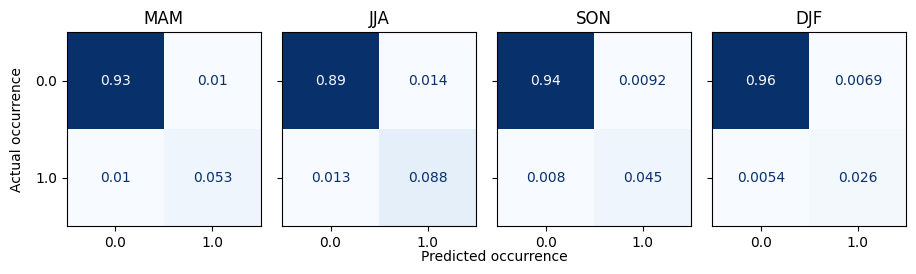

In [5]:
fig_conf, axes_conf = plt.subplots(nrows=1, ncols=4, figsize=(9.5, 2.5))
fig_conf, axes_conf = plot_confusion_matrix(fig_conf, axes_conf, label_det, pred_det)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

**Seasonal confusion matrices for detection of CPFs using the subsampled test dataset**

<a name="44"></a> <br>
### 4.4 Evaluation of skill to estimate CPFs


In [6]:
# Load test labels ford regression
test_df = CPF_test_dataset()
label_reg = Labels_regression_annual(test_df)

# Estimate CPF with trained XGBs
pred_reg = Labels_predict_regression_annual(test_df, xgb_reg)

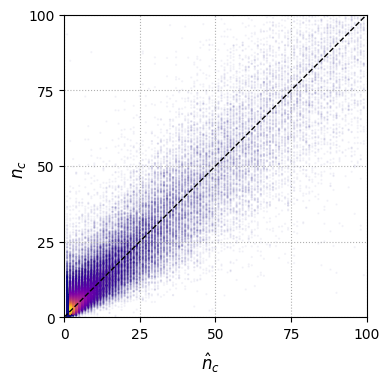

In [28]:
# Regression results

fig_reg, axes_reg = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
fig_reg, axes_reg = plot_density_scatter_annual(fig_reg, axes_reg, label_reg, pred_reg)
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

**Density scatter plots of annual simulated $n_c$ versus estimated $\hat{n}_{c}$ values from the subsampled test dataset across the CONUS.**

Note that original figure was drawn scatterdensityplot package in R whereas for better visualization, those reproduced figures were drawn by matplotlib scatter method

<a name="5"></a> <br>
## 5. Detection and estimation of CPFs over CONUS

In [8]:
# Load coordinates for 100 km grids
lat_coarse, lon_coarse, mask_coarse = hrrr_coord()

# Load basemap for geospatial plot
from mpl_toolkits.basemap import Basemap, cm
warnings.filterwarnings('ignore')

In [9]:
# detect and estimate CPFs over CONUS with trained models
arr_lab, arr_pred, zero_arr_anc, zero_arr_reg = predict_storm(xgb_detect, xgb_reg, id_file=5020)

<center><img src=https://previews.dropbox.com/p/thumb/ACUZR1rC7E1eIX031oN3Pqfm2QVILyBUu1qTJmMtrnlonJMgHHgaBh8uffEUyD_dcoBWvbyt8gOSYFXVt2opWFe8_HrcDkuk8LIaAKGtXgQ8QMMMbjvGinzaBuFFhSezQDpzNF7SPYqTwFA2mABzPJHSyhBB95smIjOrzx95hoLRdIPYZERMviUmaDpDhD9mF8C-nU8GvSy2gLLRoVM5-z7m6yHMl2mU-q_AAS8QNjd5VqIfY_bZvk_W67ZrKP6eWmj7zrOY_RZyENtUMbrp3PwEToHcLKsSLVQS7BnxSstPijipswKEt-ukZtFVruLASJjc_SJX4kHs3i4rJugX8Gnb/p.png width="950"></center>

**Original figure**: Map of (a) Composite reflectivity, (b) precipitation rate, and (c) convective labels with $>$40 dBZ on May 21, 2022, at 18:00 UTC in the native HRRR grid (3 km). In panel (c), the ground points labeled as convective (label 1) are marked by red circles for distinguished visualization.

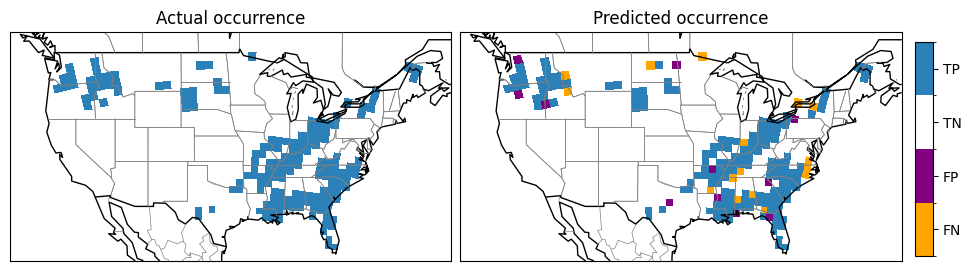

In [24]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap

cm_wb = LinearSegmentedColormap.from_list(name='wb', colors=[(1, 1, 1), (0.17, 0.5, 0.72)], N=2)

values = [-2, -1, 0, 1]
colors = ['orange', 'purple', 'white', (0.17, 0.5, 0.72)]

# Create a colormap and a normalization
cmap_four = ListedColormap(colors)
norm = BoundaryNorm(values + [2], cmap_four.N)

sm = plt.cm.ScalarMappable(cmap=cmap_four, norm=norm)
sm.set_array([])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5), constrained_layout = True)

axes[0].set_title("Actual occurrence")
m = Basemap(llcrnrlon=-130, llcrnrlat=24, urcrnrlon=-63, urcrnrlat=51, projection='merc', ax=axes[0])
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)
m.drawstates(color='0.5')
x, y = m(lon_coarse, lat_coarse)

m.pcolormesh(x, y, np.multiply(mask_coarse, arr_lab), cmap=cm_wb)

axes[1].set_title("Predicted occurrence")
m = Basemap(llcrnrlon=-130, llcrnrlat=24, urcrnrlon=-63, urcrnrlat=51, projection='merc', ax=axes[1])
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)
m.drawstates(color='0.5')
x, y = m(lon_coarse, lat_coarse)

m.pcolormesh(x, y, np.multiply(mask_coarse, arr_pred), cmap=cmap_four)

cax = fig.add_axes([axes[1].get_position().x1+0.11, axes[1].get_position().y0-0.05, 0.02, axes[1].get_position().height+0.1])
cbar = plt.colorbar(sm, cax=cax) # Similar to fig.colorbar(im, cax = cax)
cbar.ax.set_yticks([-1.5, -0.5, 0.5, 1.5])
cbar.ax.set_yticklabels(['FN', 'FP', 'TN', 'TP'])

plt.show()

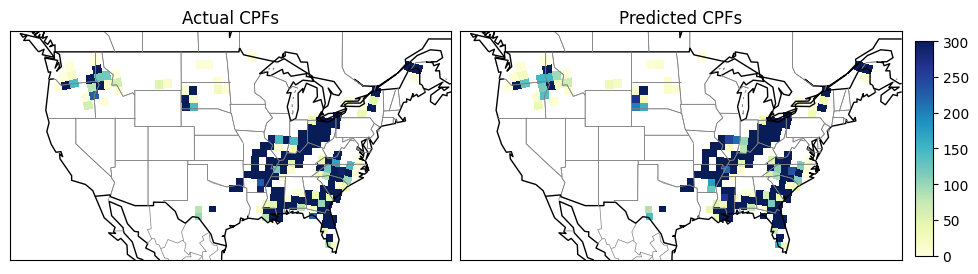

In [25]:
# Regression example

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5), constrained_layout = True)

axes[0].set_title("Actual CPFs")
m = Basemap(llcrnrlon=-130, llcrnrlat=24, urcrnrlon=-63, urcrnrlat=51, projection='merc', ax=axes[0])
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)
m.drawstates(color='0.5')
x, y = m(lon_coarse, lat_coarse)

m.pcolormesh(x, y, np.multiply(mask_coarse, zero_arr_anc), cmap=plt.cm.YlGnBu, vmin=0, vmax=300)

axes[1].set_title("Predicted CPFs")
m = Basemap(llcrnrlon=-130, llcrnrlat=24, urcrnrlon=-63, urcrnrlat=51, projection='merc', ax=axes[1])
m.drawcoastlines(linewidth=1)
m.drawcountries(linewidth=1)
m.drawstates(color='0.5')
x, y = m(lon_coarse, lat_coarse)

m.pcolormesh(x, y, np.multiply(mask_coarse, zero_arr_reg), cmap=plt.cm.YlGnBu, vmin=0, vmax=300)

norm = plt.Normalize(vmin=0, vmax=300)
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlGnBu, norm=norm)
sm.set_array([])

cax = fig.add_axes([axes[1].get_position().x1+0.11, axes[1].get_position().y0-0.05, 0.02, axes[1].get_position().height+0.1])
cbar = plt.colorbar(sm, cax=cax) # Similar to fig.colorbar(im, cax = cax)


plt.show()